# 一个使用LeNet5网络来分类minst库的例子

LeNet是贝尔实验室的研究员Yann LeCun在1989年提出的，它是最早发布的卷积神经网络之一，也是第⼀篇通过反向传播成功算法来训练卷积神经⽹络的论文。
这项⼯作代表了⼗多年来神经⽹络研究开发的成果，成为当时监督学习的主流⽅法。\
论文地址: [Gradient-based learning applied to document recognition](http://lushuangning.oss-cn-beijing.aliyuncs.com/CNN%E5%AD%A6%E4%B9%A0%E7%B3%BB%E5%88%97/Gradient-Based_Learning_Applied_to_Document_Recognition.pdf)

In [31]:
import os
import time
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<img src="../image/lenet5.png" alt="Drawing" style="width: 700px;" align="center"/>

LeNet版本有三个，分别是LeNet1，LetNet4和LeNet5。最常用的是LeNet5，如上图所示：32x32的输入图像，第一个卷积层有6个28×28 feature maps ，卷积核大小为5×5，池化层为2×2，第二个卷积层有16个10×10 feature maps 卷积核大小为5×5，池化层为2×2。卷积层后面连接的是全连接层。\
下面的代码中激活函数用到ReLU，如果换成Sigmoid，效果会很差，有时间再研究原因。

In [32]:
class LeNet5(nn.Module):
    def __init__(self, output_size):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2)
            )

        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2)
            )

        self.fc1 = nn.Sequential(
             nn.Linear(16*5*5, 120),
            nn.ReLU()
            )

        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
            )

        self.fc3 = nn.Sequential(
            nn.Linear(84, output_size),
            nn.LogSoftmax(dim=-1)
            )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)    
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

装载数据

In [33]:
def load_data(root, batch_size):
    image_size = 32
    data_tf = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), 
        transforms.ToTensor( ),
        transforms.Normalize(mean = (0.1307,), std = (0.3081,))
    ])

    train_data = datasets.MNIST(root=root,train=True,transform=data_tf,download=False)
    valid_data = datasets.MNIST(root=root,train=False,transform=data_tf,download=False)

    train_loader =torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
    valid_loader =torch.utils.data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=False)
    return train_loader, valid_loader



定义训练函数

In [34]:
def train(train_loader, valid_loader, learning_rate, epochs):
    model = LeNet5(10).to(device)

    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
    # create a loss function
    criterion = nn.NLLLoss()

    start_time = time.time()
    total_loss = []
    for epoch in range(epochs):
        model.train()
        
        train_loss, train_accs = [], []
        for _, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            result = model(data)
            loss = criterion(result, target)
            loss.backward()
            optimizer.step()

            accuarcy = (result.argmax(dim=-1).to('cpu') == target.to('cpu')).float().mean()  
            train_loss.append(loss.item())
            train_accs.append(accuarcy)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) /len(train_accs)
        print(f"[ Train | {epoch + 1:03d}/{epochs:03d} ] loss = {train_loss:.5f}, accuracy = {train_acc:.5f}")    
        
        # begin valid
        model.eval() 
        valid_loss, valid_accs = [], []
     
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            with torch.no_grad():
                result = model(data)

            loss = criterion(result, target)
            accuarcy = (result.argmax(dim=-1).to('cpu') == target.to('cpu')).float().mean()

            valid_loss.append(loss.item())
            valid_accs.append(accuarcy) 

        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        total_loss.append(valid_loss)
        print(f"[ Valid | {epoch + 1:03d}/{epochs:03d} ] loss = {valid_loss:.5f}, accuracy = {valid_acc:.5f}")

    time_span = time.time() - start_time
    print(f'Training is over, spending time {time_span/60:.1f} minutes \r\nvalid accuracy is {valid_acc:.5f}')
    return total_loss


开始训练

[ Train | 001/004 ] loss = 0.56461, accuracy = 0.81688
[ Valid | 001/004 ] loss = 0.09906, accuracy = 0.96830
[ Train | 002/004 ] loss = 0.08990, accuracy = 0.97223
[ Valid | 002/004 ] loss = 0.06559, accuracy = 0.97880
[ Train | 003/004 ] loss = 0.06114, accuracy = 0.98090
[ Valid | 003/004 ] loss = 0.04489, accuracy = 0.98540
[ Train | 004/004 ] loss = 0.04765, accuracy = 0.98555
[ Valid | 004/004 ] loss = 0.04249, accuracy = 0.98680
Training is over, spending time 1.1 minutes 
valid accuracy is 0.98680


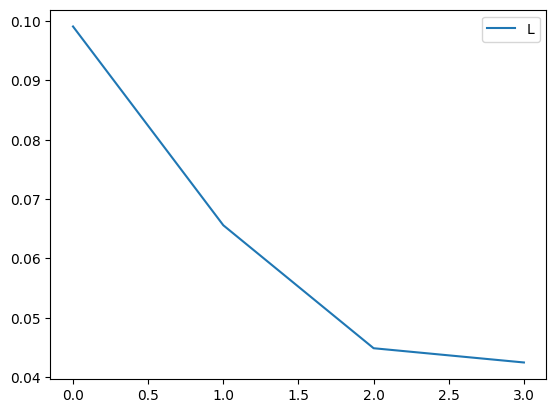

In [35]:
def main():
    data_root = Path(os.environ.get('ML_DATA_ROOT')).joinpath('mnist')
    train_loader, valid_loader = load_data(data_root, batch_size = 100);
    losses = train(train_loader, valid_loader, learning_rate = 0.01, epochs = 4)

    # 绘制损失函数曲线
    plt.figure('LeNet5')
    plt.plot(losses, label='Loss')
    plt.legend('Loss')
    plt.show()

if __name__ == "__main__":
    main()